Score and explain a `damaging` prediction.

Requires the "editquality" repository is checked out under your home directory.

In [1]:
import os.path

from revscoring import Model


model_path = os.path.expanduser("~/editquality/models/enwiki.damaging.gradient_boosting.model")
sm = Model.load(open(model_path), error_on_env_check=False)

/home/awight/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Differences between the current environment and the environment in which the model was constructed environment were detected:
 - platform 'Linux-4.9.0-6-amd64-x86_64-with-debian-9.4' mismatch with original environment 'Linux-4.16.0-x86_64-with-debian-9.4'
 - release '4.9.0-6-amd64' mismatch with original environment '4.16.0'
 - revscoring_version '2.2.2' mismatch with original environment '2.2.5'
 - version '#1 SMP Debian 4.9.82-1+deb9u3 (2018-03-02)' mismatch with original environment '#1 SMP Wed Apr 18 14:02:11 PDT 2018'


In [2]:
import mwapi
from revscoring.extractors import api

extractor = api.Extractor(mwapi.Session("https://en.wikipedia.org", user_agent="ORES-LIME demo"))

In [3]:
# Load training set
from revscoring.utilities.util import read_observations

observations = list(read_observations(open(os.path.expanduser("~/editquality/datasets/enwiki.labeled_revisions.w_cache.20k_2015.json"))))

Pick a revision, extract the features and score.

In [9]:
import numpy as np

# Add to list
# rev_to_score = 846560713
# Vandalism
# rev_to_score = 846560716
# Wiki talk
rev_to_score = 846569040
features = [str(f) for f in sm.features]
feature_values = np.array(list(extractor.extract(rev_to_score, sm.features)))

prediction = sm.score(feature_values)

print("https://en.wikipedia.org/?diff={}".format(rev_to_score))
print(np.array(list(zip(features, feature_values))))
print(prediction)

https://en.wikipedia.org/?diff=846569040
[['feature.revision.page.is_articleish' '0.0']
 ['feature.revision.page.is_mainspace' '0.0']
 ['feature.revision.page.is_draftspace' '0.0']
 ['feature.log((wikitext.revision.parent.chars + 1))' '10.59635969527664']
 ['feature.log((AggregatorsScalar(<datasource.tokenized(datasource.revision.parent.text)>) + 1))'
  '9.546312483555713']
 ['feature.log((AggregatorsScalar(<datasource.wikitext.revision.parent.words>) + 1))'
  '8.600430789986293']
 ['feature.log((AggregatorsScalar(<datasource.wikitext.revision.parent.uppercase_words>) + 1))'
  '5.043425116919247']
 ['feature.log((wikitext.revision.parent.headings + 1))'
  '3.295836866004329']
 ['feature.log((wikitext.revision.parent.wikilinks + 1))'
  '5.298317366548036']
 ['feature.log((wikitext.revision.parent.external_links + 1))'
  '2.995732273553991']
 ['feature.log((wikitext.revision.parent.templates + 1))'
  '3.295836866004329']
 ['feature.log((wikitext.revision.parent.ref_tags + 1))' '0.0']
 ['

Set up a LIME explainer for this model.  It will randomly perturb features of the revision being scored.

In [47]:
# TODO: Also explain as text, using our own explainer to run variations.
from lime.lime_tabular import LimeTabularExplainer

def score(samples):
    raw_results = [np.array([sm.score(v)["probability"][t] for t in [False, True]]) for v in samples]
    return np.array(raw_results)

# Transform training data into a numpy matrix.
train = np.array([np.array([o["cache"][k] for k in features]) for o in observations])

# Identify which features are booleans.  Can we introspect the features?
categorical_features = [0, 1, 2, 45, 46, 47, 48, 49, 50, 51, 53, 54]

explainer = LimeTabularExplainer(
    train,
    mode="classification",
    feature_names=features,
    categorical_features=categorical_features,
    class_names=["not damaging", "damaging"],
    discretize_continuous=False
)

Create an explainer for this prediction.

In [51]:
predicted_label = int(prediction["prediction"])
exp = explainer.explain_instance(
    np.array(feature_values),
    score,
    num_features=20,
    labels=(predicted_label,)
)


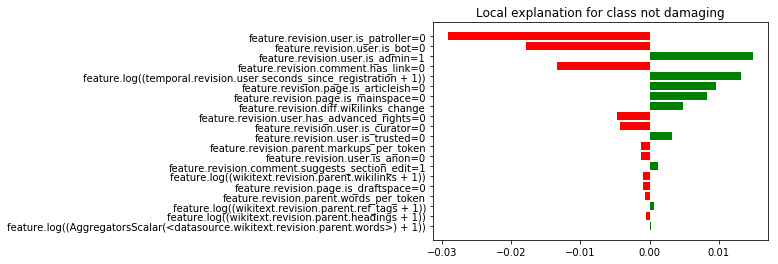

In [52]:
%matplotlib inline
fig = exp.as_pyplot_figure(label=predicted_label)

In [50]:
exp.as_list(label=predicted_label)

[('feature.revision.user.is_patroller=0', -0.02885656431020327),
 ('feature.revision.user.is_bot=0', -0.017047548128635),
 ('feature.revision.user.is_admin=1', 0.016879363247238315),
 ('feature.revision.comment.has_link=0', -0.013085758344046244),
 ('feature.log((temporal.revision.user.seconds_since_registration + 1))',
  0.012138254005540654),
 ('feature.revision.page.is_draftspace=0', 0.011583228187620071),
 ('feature.revision.page.is_articleish=0', 0.009507456785575104),
 ('feature.revision.page.is_mainspace=0', 0.008447444624258619),
 ('feature.revision.comment.suggests_section_edit=1', 0.002015611098428384),
 ('feature.revision.user.has_advanced_rights=0', -0.0009971044755248304)]

In [66]:
import json

def compare_injected_features(rev_id, cache):
    feature_values = np.array(list(extractor.extract(rev_id, sm.features)))
    baseline = sm.score(feature_values)["probability"][True]
    
    inject_json = json.dumps(cache)
    feature_values = np.array(list(extractor.extract(rev_id, sm.features, cache=cache)))
    perturbed = sm.score(feature_values)["probability"][True]
    
    print("Damaging changed {} -> {} after injecting {}".format(baseline, perturbed, inject_json))

compare_injected_features(rev_to_score, {"feature.revision.user.is_patroller": 1})
compare_injected_features(rev_to_score, {"feature.english.badwords.revision.diff.match_delta_sum": 3, "feature.english.badwords.revision.diff.match_delta_increase": 3})

Damaging changed 0.004514814339604508 -> 0.0027323188714148384 after injecting {"feature.revision.user.is_patroller": 1}
Damaging changed 0.004514814339604508 -> 0.0035872217248806 after injecting {"feature.english.badwords.revision.diff.match_delta_increase": 3, "feature.english.badwords.revision.diff.match_delta_sum": 3}
